# FAIKR module 3 project

#Lorenzo Venieri
#Luca Zucchini

## Introduction

....

In [1]:
!pip install pgmpy

## Dataset

768 rows, 9 columns

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("diabetes.csv")
df_raw.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data discretization

Data need to be discretized because Pgmpy doesn't support learning parameters from continuous variables.

In [18]:
#Printing the min and max values of age in order to better discretize the age parameter
print('Age range is: ', np.min(df_raw['Age']), ' - ', np.max(df_raw['Age']))

Age range is:  21  -  81


In [ ]:
...

## Network


"In this chapter both the structure of the network, created from scratch by analyzing scientific papers related to the topic, and the parameter learning process are taken into account.

In particular, a variety of methods related to the analysis of Bayesian Networks are explored."

### Showing the network

A graphical preliminary overview of the network is shown using the visual library of pgmpy, the acronyms related to dataset attributes are the followings:

...


In [20]:
!pip install daft

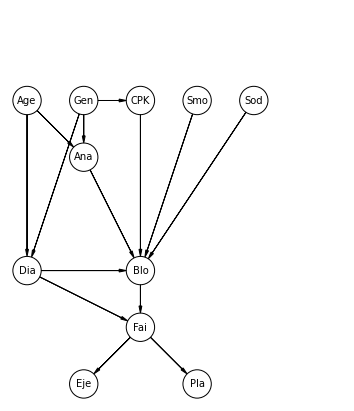

In [22]:
import daft
import matplotlib.pyplot as plt
from daft import PGM

pgm = PGM(shape=[6, 7])

pgm.add_node(daft.Node('Gen', r"Gen", 2, 6))
pgm.add_node(daft.Node('Age', r"Age", 1, 6))
pgm.add_node(daft.Node('CPK', r"CPK", 3, 6))
pgm.add_node(daft.Node('Smo', r"Smo", 4, 6))
pgm.add_node(daft.Node('Sod', r"Sod", 5, 6))


pgm.add_node(daft.Node('Ana', r"Ana", 2, 5))

pgm.add_node(daft.Node('Dia', r"Dia", 1, 3))
pgm.add_node(daft.Node('Blo', r"Blo", 3, 3))

pgm.add_node(daft.Node('Fai', r"Fai", 3, 2))

pgm.add_node(daft.Node('Eje', r"Eje", 2, 1))
pgm.add_node(daft.Node('Pla', r"Pla", 4, 1))

pgm.add_edge('Gen', 'CPK')
pgm.add_edge('Gen', 'Dia')
pgm.add_edge('Age', 'Dia')
pgm.add_edge('Age', 'Ana')
pgm.add_edge('Gen', 'Ana')
pgm.add_edge('Dia', 'Blo')
pgm.add_edge('CPK', 'Blo')
pgm.add_edge('Ana', 'Blo')
pgm.add_edge('Smo', 'Blo')
pgm.add_edge('Sod', 'Blo')
pgm.add_edge('Blo', 'Fai')
pgm.add_edge('Dia', 'Fai')
pgm.add_edge('Fai', 'Eje')
pgm.add_edge('Fai', 'Pla')

pgm.render()
plt.show()


Examples of connections between nodes (e.g. direct cause, causal trail) refering to this specific Network are here shown:

#Direct cause

#Causal trail

#Common effect

## Creating the network

Connections between nodes have been implemented from scratch refering to a variety of scientific medical sources. Being the causal links in the medical field particularly challenging to model (i.e. often a huge variety of attributes are interlaced, causing directly or indirectly effects on each others) in this work only links that have been considered particularly relevant were defined.

Some of the connections are here explained and referenced:


In [23]:
from pgmpy.models import BayesianModel

...

Ellipsis

###Analyzing the network

Follows a series of experiments done on the network by applying a variety of methods provided by the pgmpy library in order to see in practice all the concepts addressed during the course.

In [ ]:
# Showing all the nodes of the model
model.nodes()

In [ ]:
# Showing all the edges of the model
model.edges()

In [ ]:
# Local independecies of a single node
model.local_independencies("high_blood_pressure")

In [ ]:
# Checking d-separation between variables with and without evidence
# Two sets of nodes X, Y are d-separated given Z if there is no active trail between any X ∈ X and Y ∈ Y given Z

print(model.is_dconnected("high_blood_pressure", "creatinine_phosphokinase"))
print(model.is_dconnected("serum_sodium", "diabetes",observed=["anaemia"] ))

In [ ]:
# Function is_irrelevant made from scratch by the definition of irrelevance given during the course 

def is_irrelevant (node1,node2,evidence):
  if ((node2 in (model.get_ancestral_graph(node1)and model.get_ancestral_graph(evidence))) and model.is_dconnected(node1, node2,observed=evidence )):
    print("The node {0} is not irrelevant with resepect to {1}, given the evidence {2}.".format(node1, node2, evidence))
  else:
    print("The node {0} is irrelevant with resepect to {1}, given the evidence {2}".format(node1, node2, evidence))


is_irrelevant("ejection_fraction", "diabetes", "heart_failure")

In [25]:
# Checking active trails from high blood pressure given the evidence diabetes
model.active_trail_nodes('high_blood_pressure', observed='diabetes')

NameError: name 'model' is not defined

In [ ]:
# Checking the markov blanket of the node heart failure
model.get_markov_blanket("heart_failure")

### Parameter learning

Learning Bayesian networks from data, knowing the structure of the network, boils down to parameter estimation. In pgmpy a variety of estimators is available, going from IVestimator to SEMestimator, but the main choice for this problem fell on two of them: Maximum Likelihood and Bayesian Estimator.

MLE, which depends solely on the outcomes of observed data, could be a reasonable simple starting point, however, it is notorious for becoming easily biased when the data is minimal. Moreover, in situations where observed data is sparse, Bayesian estimation’s incorporation of prior knowledge can help in attaining a more accurate model. 

On the other hand, unreliable priors can lead to a slippery slope of highly biased models that require large amounts of seen data to remedy; so priors need to be well defined and contain relevant insight to the problem in order to avoid that. 

Taken into consideration pros and cons of both approaches, given the minimal dataset used for this work the Bayesian Estimator is choosen.

Pgmpy also offer a variety of possible priors, among them a possible choice is Bayesian Dirichlet equivalent uniform prior (BDeu), choosen with its default settings (i.e. equivalent_sample_size equal to 5).

In the following cell the parameter estimation process takes place and the learned CPTs are shown.

In [26]:
from pgmpy.estimators import BayesianEstimator

model.cpds = []
model.fit(data=df, estimator=BayesianEstimator, prior_type="BDeu")

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd, '\n')

/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


AttributeError: module 'pandas' has no attribute 'Panel'

In [ ]:
# Checking the validity of the model 
# This method checks if the sum of the probabilities for each state is equal to 1 (tol=0.01) and if the CPDs associated with nodes are consistent with their parents.
model.check_model()